In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble.forest import _generate_sample_indices

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

from tqdm import tqdm

import pickle

from joblib import Parallel, delayed

In [2]:
# Should use this class to generate CIFAR fig..
class LifelongForest:
    """
    Lifelong Forest class.
    """
    def __init__(self, acorn=None):
        """
        Two major things the Forest Class needs access to:
            1) the realized random forest model (self.models_ is a list of forests, 1 for each task)
            2) old data (to update posteriors when a new task is introduced)
        """
        self.models_ = []
        self.X_ = []
        self.y_ = []
        self.n_tasks = 0
        self.n_classes = None
        
        if acorn is not None:
            np.random.seed(acorn)
    
    def new_forest(self, X, y, n_estimators=200, max_samples=0.32,
                        bootstrap=True, max_depth=30, min_samples_leaf=1,
                        acorn=None):
        """
        Input
        X: an array-like object of features; X.shape == (n_samples, n_features)
        y: an array-like object of class labels; len(y) == n_samples
        n_estimators: int; number of trees to construct (default = 200)
        max_samples: float in (0, 1]: number of samples to consider when 
            constructing a new tree (default = 0.32)
        bootstrap: bool; If True then the samples are sampled with replacement
        max_depth: int; maximum depth of a tree
        min_samples_leaf: int; minimum number of samples in a leaf node
        
        Return
        model: a BaggingClassifier fit to X, y
        """
        
        if X.ndim == 1:
            raise ValueError('1d data will cause headaches down the road')
            
        if acorn is not None:
            np.random.seed(acorn)
            
        self.X_.append(X)
        self.y_.append(y)
            
        n = X.shape[0]
        K = len(np.unique(y))
        
        if self.n_classes is None:
            self.n_classes = K
        
        max_features = int(np.ceil(np.sqrt(X.shape[1])))

        model=BaggingClassifier(DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf,
                                                         max_features = max_features),
                                  n_estimators=n_estimators,
                                  max_samples=max_samples,
                                  bootstrap=bootstrap)

        model.fit(X, y)
        self.models_.append(model)
        self.n_tasks += 1
        self.n_classes = len(np.unique(y))
        
        return model
    
    
    def _get_leaves(self, estimator):
        """
        Internal function to get leaf node ids of estimator.
        
        Input
        estimator: a fit DecisionTreeClassifier
        
        Return
        leaf_ids: numpy array; an array of leaf node ids
        
        Usage
        _estimate_posteriors(..)
        """
        
        # adapted from https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html
        n_nodes = estimator.tree_.node_count
        children_left = estimator.tree_.children_left
        children_right = estimator.tree_.children_right
        feature = estimator.tree_.feature
        threshold = estimator.tree_.threshold

        leaf_ids = []
        stack = [(0, -1)] 
        while len(stack) > 0:
            node_id, parent_depth = stack.pop()

            # If we have a test node
            if (children_left[node_id] != children_right[node_id]):
                stack.append((children_left[node_id], parent_depth + 1))
                stack.append((children_right[node_id], parent_depth + 1))
            else:
                leaf_ids.append(node_id)

        return np.array(leaf_ids)
    
    
    def _finite_sample_correction(self, class_probs, row_sums):
        """
        An internal function for finite sample correction of posterior estimation.
        
        Input
        class_probs: numpy array; array of posteriors to correct
        row_sums: numpy array; array of partition counts
        
        Output
        class_probs: numpy array; finite sample corrected posteriors
        
        Usage
        _estimate_posteriors(..)
        
        """
    
        where_0 = np.argwhere(class_probs == 0)
        for elem in where_0:
            class_probs[elem[0], elem[1]] = 1 / (2 * row_sums[elem[0], None])
        where_1 = np.argwhere(class_probs == 1)
        for elem in where_1:
            class_probs[elem[0], elem[1]] = 1 - 1 / (2 * row_sums[elem[0], None])
    
        return class_probs
    
    
    def _estimate_posteriors(self, test, representation=0, decider=0, subsample=1, acorn=None):
        """
        An internal function to estimate the posteriors.
        
        Input
        task_number: int; indicates which model in self.model_ to use
        test: array-like; test observation
        in_task: bool; True if test is an in-task observation(s)
        subsample: float in (0, 1]; proportion of out-of-task samples to use to
            estimate posteriors
            
        Return
        probs: numpy array; probs[i, k] is the probability of observation i
            being class k
            
        Usage
        predict(..)
        """
        
        if acorn is not None:
            acorn = np.random.seed(acorn)
            
        if representation==decider:
            in_task=True
        else:
            in_task=False
            
        train = self.X_[decider]
        y = self.y_[decider]
            
        model = self.models_[representation]

        n, d = train.shape
        
        if test.ndim > 1:
            m, d_ = test.shape
        else:
            m = len(test)
            d_ = 1
        
        size = len(np.unique(y))
        class_counts = np.zeros((m, size))
        for tree in model:
            # get out of bag indicies
            if in_task:
                prob_indices = _generate_unsampled_indices(tree.random_state, n)
                # in_bag_idx = _generate_sample_indices(tree.random_state, n) # this is not behaving as i expected
            else:
                prob_indices = np.random.choice(range(n), size=int(subsample*n), replace=False)

            leaf_nodes = self._get_leaves(tree)
            unique_leaf_nodes = np.unique(leaf_nodes)

            # get all node counts
            node_counts = tree.tree_.n_node_samples
            # get probs for eval samples
            posterior_class_counts = np.zeros((len(unique_leaf_nodes), size))

            for prob_index in prob_indices:
                temp_node = tree.apply(train[prob_index].reshape(1, -1)).item()
                posterior_class_counts[np.where(unique_leaf_nodes == temp_node)[0][0], y[prob_index]] += 1

            # total number of points in a node
            row_sums = posterior_class_counts.sum(axis=1)

            # no divide by zero
            row_sums[row_sums == 0] = 1

            # posteriors
            class_probs = (posterior_class_counts / row_sums[:, None])
            # posteriors with finite sampling correction

            class_probs = self._finite_sample_correction(class_probs, row_sums)

            # posteriors as a list
            class_probs.tolist()

            partition_counts = np.asarray([node_counts[np.where(unique_leaf_nodes == x)[0][0]] for x in tree.apply(test)])
            # get probability for out of bag samples
            eval_class_probs = [class_probs[np.where(unique_leaf_nodes == x)[0][0]] for x in tree.apply(test)]
            eval_class_probs = np.array(eval_class_probs)
            # find total elements for out of bag samples
            elems = np.multiply(eval_class_probs, partition_counts[:, np.newaxis])
            # store counts for each x (repeat fhis for each tree)
            class_counts += elems
        # calculate p(y|X = x) for all x's
        probs = class_counts / class_counts.sum(axis=1, keepdims=True)

        return probs


    def predict(self, test, representation=0, decider='all', subsample=1, acorn=None):
        """
        Predicts the class labels for each sample in test.
        
        Input
        test: array-like; either a 1d array of length n_features
            or a 2d array of shape (m, n_features) 
        task_number: int; task number 
        """
        
        size=len(np.unique(self.y_[decider]))
        sum_posteriors = np.zeros((test.shape[0], size))
        
        if representation is 'all':
            for i in range(self.n_tasks):
                sum_posteriors += self._estimate_posteriors(test,
                                                            i,
                                                            decider,
                                                            subsample,
                                                            acorn)
            
        else:
            sum_posteriors += self._estimate_posteriors(test,
                                                        representation,
                                                        decider,
                                                        subsample,
                                                        acorn)
                
        return np.argmax(sum_posteriors, axis=1)

In [3]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def homogenize_labels(a):
    u = np.unique(a)
    return np.array([np.where(u == i)[0][0] for i in a])

In [4]:
n_tasks=10
train_file = 'cifar-100-python/train'
unpickled_train = unpickle(train_file)
train_keys = list(unpickled_train.keys())
fine_labels = np.array(unpickled_train[train_keys[2]])

train_data = unpickled_train[list(train_keys)[-1]]
class_idx = [np.where(fine_labels == u)[0] for u in np.unique(fine_labels)]

train_labels = -1*np.ones(train_data.shape[0])
for i, class_ in enumerate(class_idx):
    train_labels[class_] = i
    
train_by_task = [np.concatenate(class_idx[i*n_tasks: (i+1)*n_tasks]) for i in range(n_tasks)]

K = int(len(class_idx)/n_tasks)

test_file = 'cifar-100-python/test'
unpickled_test = unpickle(test_file)
test_keys = list(unpickled_test.keys())
test_labels = np.array(unpickled_test[test_keys[2]])

test_data = unpickled_test[test_keys[-1]]
test_class_idx = [np.where(test_labels == u)[0] for u in np.unique(test_labels)]
test_by_task = [np.concatenate(test_class_idx[i*n_tasks: (i+1)*n_tasks]) for i in range(n_tasks)]

In [80]:
def recruit_trees(forest, X, y, n_trees=50, validation_split=0.33, samples_per_tree=0.67, parallel=True, acorn=None):
    if acorn is not None:
        np.random.seed(acorn)
                
    n,d=X.shape
    size=len(np.unique(y))
    
    validation_indices = np.random.choice(n, int(n*validation_split), replace=False)
    estimation_indices = np.array([i for i in range(n) if i not in validation_indices])
    
    X_validation = X[validation_indices]
    y_validation = y[validation_indices]
            
    best_trees = []
    best_errors = np.ones(n_trees)
    best_indices = np.zeros(n_trees)
    
    posterior_info = estimate_posteriors(forest, 
                                              X[estimation_indices], 
                                              y[estimation_indices], 
                                              samples_per_tree=samples_per_tree,
                                              parallel=parallel
                                             )
    
    for i, tree in enumerate(forest):
        y_hat = predict([posterior_info[i]], X_validation)
        error = np.sum(y_hat != y_validation) / len(y_validation)

        if error < max(best_errors):
            idx = len(best_errors) - np.sum(error < best_errors)

            best_trees = np.concatenate((best_trees[:idx], [tree], best_trees[idx:]))
            best_errors = np.concatenate((best_errors[:idx], [error], best_errors[idx:]))
            best_indices = np.concatenate((best_indices[:idx], [error], best_indices[idx:]))

        if len(best_trees) > n_trees:
            best_trees = best_trees[:n_trees]
            best_errors = best_errors[:n_trees]
            best_indices = best_indices[:n_trees]
                
    return best_trees

In [81]:
def get_leaves(estimator):
    """
    Internal function to get leaf node ids of estimator.

    Input
    estimator: a fit DecisionTreeClassifier

    Return
    leaf_ids: numpy array; an array of leaf node ids

    Usage
    _estimate_posteriors(..)
    """

    # adapted from https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html
    n_nodes = estimator.tree_.node_count
    children_left = estimator.tree_.children_left
    children_right = estimator.tree_.children_right
    feature = estimator.tree_.feature
    threshold = estimator.tree_.threshold

    leaf_ids = []
    stack = [(0, -1)] 
    while len(stack) > 0:
        node_id, parent_depth = stack.pop()

        # If we have a test node
        if (children_left[node_id] != children_right[node_id]):
            stack.append((children_left[node_id], parent_depth + 1))
            stack.append((children_right[node_id], parent_depth + 1))
        else:
            leaf_ids.append(node_id)

    return np.array(leaf_ids)
    
    
def finite_sample_correction(class_probs, row_sums):
    """
    An internal function for finite sample correction of posterior estimation.

    Input
    class_probs: numpy array; array of posteriors to correct
    row_sums: numpy array; array of partition counts

    Output
    class_probs: numpy array; finite sample corrected posteriors

    Usage
    _estimate_posteriors(..)

    """

    where_0 = np.argwhere(class_probs == 0)
    for elem in where_0:
        class_probs[elem[0], elem[1]] = 1 / (2 * row_sums[elem[0], None])
    where_1 = np.argwhere(class_probs == 1)
    for elem in where_1:
        class_probs[elem[0], elem[1]] = 1 - 1 / (2 * row_sums[elem[0], None])

    return class_probs

# def predict(forest, X, y, X_test):
#     m, d = X_test.shape
#     n, _ = X.shape
    
#     size = len(np.unique(y))
#     class_counts = np.zeros((m, size))
        
#     for j, tree in enumerate(forest):
#         prob_indices = np.random.choice(n, n, replace=False)

#         leaf_nodes = get_leaves(tree)
#         unique_leaf_nodes = np.unique(leaf_nodes)

#         # get all node counts
#         node_counts = tree.tree_.n_node_samples
#         # get probs for eval samples
#         posterior_class_counts = np.zeros((len(unique_leaf_nodes), size))

#         for prob_index in prob_indices:
#             temp_node = tree.apply(X[prob_index].reshape(1, -1)).item()
#             posterior_class_counts[np.where(unique_leaf_nodes == temp_node)[0][0], y[prob_index]] += 1

#         # total number of points in a node
#         row_sums = posterior_class_counts.sum(axis=1)

#         # no divide by zero
#         row_sums[row_sums == 0] = 1

#         # posteriors
#         class_probs = (posterior_class_counts / row_sums[:, None])
#         # posteriors with finite sampling correction

#         class_probs = finite_sample_correction(class_probs, row_sums)

#         # posteriors as a list
#         class_probs.tolist()

#         partition_counts = np.asarray([node_counts[np.where(unique_leaf_nodes == x)[0][0]] for x in tree.apply(X_test)])

#         # get probability for out of bag samples
#         eval_class_probs = [class_probs[np.where(unique_leaf_nodes == x)[0][0]] for x in tree.apply(X_test)]
#         eval_class_probs = np.array(eval_class_probs)

#         # find total elements for out of bag samples
#         elems = np.multiply(eval_class_probs, partition_counts[:, np.newaxis])

#         # store counts for each x (repeat fhis for each tree)
#         class_counts += elems

#     # calculate p(y|X = x) for all x's
#     probs = class_counts / class_counts.sum(axis=1, keepdims=True)
    
#     return np.argmax(probs, axis=1)

In [87]:
import time

def find_best_forest(n_try, forest, X, y, n_trees=50, validation_split=0.33, samples_per_tree=0.67, parallel=True, acorn=None):
    if acorn is not None:
        np.random.seed(acorn)
                
    n,d=X.shape
    size=len(np.unique(y))
    
    validation_indices = np.random.choice(n, int(n*validation_split), replace=False)
    estimation_indices = np.array([i for i in range(n) if i not in validation_indices])
    
    X_validation = X[validation_indices]
    y_validation = y[validation_indices]
    
    m, _ = X_validation.shape
    class_counts = np.zeros((m, size))
    
    T = len(forest)
    
    best_error = 1
    
    start = time.time()
    
    for i in range(n_try):
        tree_indices = np.random.choice(T, n_trees, replace=False)
        temp_model = forest[tree_indices]
        
        posterior_info = estimate_posteriors(temp_model, 
                                             X[estimation_indices], 
                                             y[estimation_indices], 
                                             samples_per_tree=samples_per_tree,
                                             parallel=parallel
                                            )
        y_hat = predict(posterior_info, X_validation)
        error = np.sum(y_hat != y_validation) / len(y_validation)
                        
        if error < best_error:
            best_error = error
            best_model = temp_model
            best_indices = tree_indices
            
    print(time.time() - start)


    return best_model

In [98]:
def recruit_experiment(n_mc, train_data, labels, train_by_task, test, test_labels, test_by_task, task=9, 
                       n_task='all', n_trees=1, recruit_params=None, parallel=True, acorn=None):
    
    J = len(train_by_task)
    
    errors = np.zeros((6, n_mc))
    
    if acorn is not None:
        np.random.seed(acorn)
        
    if n_task == 'all':
        n_task = train_data[train_by_task[task]].shape[0]
        
    for i in range(n_mc):
        lifelong_forest = LifelongForest()

        for j in range(J):
            if j == task:
                indices = np.random.choice(train_data[train_by_task[task]].shape[0], n_task, replace=False)
                X_ = train_data[train_by_task[task]][indices]
                y_ = homogenize_labels(labels[train_by_task[task]][indices])
                lifelong_forest.new_forest(X_, y_, n_estimators=n_trees)
            else:
                X = train_data[train_by_task[j]]
                y = homogenize_labels(labels[train_by_task[j]]) 
                lifelong_forest.new_forest(X, y, n_estimators=n_trees)
            
        X_test = test[test_by_task[task]]
        y_test = homogenize_labels(test_labels[test_by_task[task]])
        
        best_trees = recruit_trees(forest, 
                                       X_, 
                                       y_, 
                                       *recruit_params,
                                       parallel=parallel
                                      )
        
        temp_posterior_info = estimate_posteriors(best_trees, X_, y_, parallel=parallel)
        yhat_recruit = predict(temp_posterior_info, X_test)
        errors[0, i] = np.sum(yhat_recruit != y_test)/len(y_test)
            
            
        # slow
        yhat_task = lifelong_forest.predict(test[test_by_task[task]], representation=task, decider=task)
        errors[1, i] = np.sum(yhat_task != y_test) / len(y_test)
        
        
        combo_forest = np.concatenate((forest[:int(n_trees/2)], lifelong_forest.models_[task][:int(n_trees/2)]))
        temp_posterior_info = estimate_posteriors(combo_forest, X_, y_, parallel=parallel)
        yhat_combo = predict(temp_posterior_info, X_test)
        errors[2, i] = np.sum(yhat_combo != y_test) / len(y_test)
        
        
        all_non_task_trees = np.concatenate([lifelong_forest.models_[i] for i in range(len(lifelong_forest.models_)) if i != task])
        T = len(all_non_task_trees)
        random_indices = np.random.choice(T, n_trees, replace=False)
        random_forest = all_non_task_trees[random_indices]
        temp_posterior_info = estimate_posteriors(random_forest, X_, y_, parallel=parallel)
        yhat_random = predict(temp_posterior_info, X_test)
        errors[3, i] = np.sum(yhat_random != y_test)/len(y_test)
        
        
#         best_forest = find_best_forest(50, all_non_task_trees, X_, y_, n_trees=n_trees)
#         temp_posterior_info = estimate_posteriors(best_forest, X_, y_, parallel=parallel)
#         yhat_bf = predict(temp_posterior_info, X_test)
#         errors[4, i] = np.sum(yhat_bf != y_test)/len(y_test)
        
        
        #slow
        yhat_lf = lifelong_forest.predict(test[test_by_task[task]], representation='all', decider=task)
        errors[5, i] = np.sum(yhat_lf != y_test) / len(y_test)
        
    return errors

In [95]:
def estimate_posteriors(forest, X, y, samples_per_tree=0.67, parallel=True):
    n = X.shape[0]
    size = len(np.unique(y))

    def worker(idx_tree):
        idx = idx_tree[0]
        tree = idx_tree[1]
        # Get indices of estimation set, i.e. those NOT used
        # in learning trees of the forest.
#         sampled_indices = self.model.estimators_samples_[idx]
#         unsampled_indices = np.delete(np.arange(0, n), sampled_indices)

#         np.random.shuffle(unsampled_indices)
#         num_est = int(self.frac_est * n)

        estimation_indices = np.random.choice(n, int(n*samples_per_tree), replace=False)

        # print("n", n)
        # print("STRUCT", len(np.unique(sampled_data)))
        # print("EST", len(estimation_indices))
        # print("EVAL", len(eval_indices))

        # Count the occurences of each class in each leaf node,
        # by first extracting the leaves.
        # node_counts = tree.tree_.n_node_samples
        unique_leaf_nodes = get_leaves(tree)

        class_counts_per_leaf = np.zeros(
            (len(unique_leaf_nodes), size)
        )

        # Drop each estimation example down the tree, and record its 'y' value.
        for i in estimation_indices:
            temp_node = tree.apply(X[i].reshape((1, -1))).item()
            class_counts_per_leaf[
                np.where(unique_leaf_nodes == temp_node)[0][0], y[i]
            ] += 1

        # Count the number of data points in each leaf in.
        n_per_leaf = class_counts_per_leaf.sum(axis=1)
        n_per_leaf[n_per_leaf == 0] = 1  # Avoid divide by zero.

        # Posterior probability distributions in each leaf.
        # Each row is length num_classes.
        posterior_per_leaf = np.divide(
            class_counts_per_leaf,
            np.repeat(n_per_leaf.reshape((-1, 1)), size, axis=1),
        )
        posterior_per_leaf = finite_sample_correction(
            posterior_per_leaf, n_per_leaf
        )
        posterior_per_leaf = posterior_per_leaf.tolist()

        # Posterior probability for each element of the evaluation set.
#         eval_posteriors = np.array(
#             [
#                 posterior_per_leaf[np.where(unique_leaf_nodes == node)[0][0]]
#                 for node in tree.apply(X[valida])
#             ]
#         )


        return (posterior_per_leaf, tree, unique_leaf_nodes)

    if parallel:
        uncertainty_per_tree = Parallel(n_jobs=-2)(
            delayed(worker)(idx_tree) for idx_tree in enumerate(forest)
        )
    else:
        uncertainty_per_tree = []
        for idx_tree in enumerate(forest):
            uncertainty_per_tree.append(worker(idx_tree))

    posterior_info = []
    for elem in uncertainty_per_tree:
        posterior_info.append(elem[0:3])

    return posterior_info


def predict(posterior_info, X):
    def worker(tree_fields):
        posterior_per_leaf = tree_fields[0]
        tree = tree_fields[1]
        unique_leaf_nodes = tree_fields[2]

        # Posterior probability for each element of the evaluation set.
        eval_posteriors = [
            posterior_per_leaf[np.where(unique_leaf_nodes == node)[0][0]]
            for node in tree.apply(X)
        ]

        return np.array(eval_posteriors)

    posteriors = np.array(
        Parallel(n_jobs=-2)(
            delayed(worker)(tree_fields) for tree_fields in posterior_info
        )
    )
    return np.argmax(np.mean(posteriors, axis=0), axis=1)

In [99]:
ns = 10*np.array([50, 100, 200, 350, 500])

n_mc=20

mean_errors = np.zeros((6, len(ns)))
std_errors = np.zeros((6, len(ns)))

n_trees=50
recruit_params = (n_trees, 0.33, 0.67)


for i, n in enumerate(tqdm(ns)):
    temp_errors = recruit_experiment(n_mc, train_data, train_labels, train_by_task, test_data, test_labels, test_by_task,
                                    task=9, n_task=n, n_trees=n_trees, recruit_params=recruit_params)
    
    mean_errors[:, i] = np.mean(temp_errors, axis=1)
    std_errors[:, i] = np.std(temp_errors, axis=1, ddof=1)










  0%|          | 0/5 [00:00<?, ?it/s]








 20%|██        | 1/5 [1:29:47<5:59:10, 5387.67s/it]








 40%|████      | 2/5 [3:04:29<4:33:47, 5475.98s/it]








 60%|██████    | 3/5 [4:51:15<3:11:49, 5754.94s/it]








 80%|████████  | 4/5 [6:56:51<1:44:49, 6289.29s/it]








100%|██████████| 5/5 [9:21:17<00:00, 7002.30s/it]  

In [100]:
pickle.dump(mean_errors, open('mean_errors_recruit_experiment.pkl', 'wb'))
pickle.dump(std_errors, open('std_errors_recruit_experiment.pkl', 'wb'))

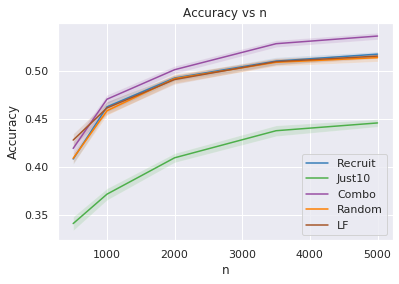

In [102]:
fig, ax = plt.subplots(1,1)
sns.set()

mean_error = 1-mean_errors
std_error = std_errors / np.sqrt(n_mc)

colors = sns.color_palette('Set1', n_colors=mean_error.shape[0] + 1)
labels = ['Recruit', 'Just10', 'Combo', 'Random', 'BF', 'LF']
not_included = ['BF']

for i, error_ in enumerate(mean_error):
    if labels[i] in not_included:
        continue
    ax.plot(ns, mean_error[i], c=colors[i+1], label=labels[i])
    ax.fill_between(ns, 
            mean_error[i] + 1.96*std_error[i], 
            mean_error[i] - 1.96*std_error[i], 
            where=mean_error[i] + 1.96*std_error[i] >= mean_error[i] - 1.96*std_error[i], 
            facecolor=colors[i+1], 
            alpha=0.15,
            interpolate=False)



ax.set_title('Accuracy vs n')
ax.set_ylabel('Accuracy')
ax.set_xlabel('n')

# ax.set_xticks([])
# ax.set_yticks([])

ax.legend()
plt.savefig('cifar-recruit-task10.pdf')
plt.savefig('cifar-recruit-task10.svg')
plt.savefig('cifar-recruit-task10.png', dpi=500)

In [10]:
np.random.seed(1)

lifelong_forest = LifelongForest()

n_trees=10


for i in range(n_tasks-1):
    X = train_data[np.concatenate(class_idx[i*n_tasks: (i+1)*n_tasks])]
    labels = homogenize_labels(np.concatenate([n_tasks*i*np.ones(500) + j for j in range(n_tasks*i, n_tasks*(i+1))]))
    lifelong_forest.new_forest(X, labels, n_estimators=n_trees)

In [190]:
X_test = test_data[test_by_task[-1]]
y_test = homogenize_labels(test_labels[test_by_task[-1]])

y_hat = predict(best_forest, X, labels, X_test)

In [192]:
np.sum(y_test == y_hat)/len(y_hat)

0.409

In [59]:
lifelong_forest_10 = LifelongForest()

n_trees=50


for i in range(9, 10):
    X = train_data[np.concatenate(class_idx[i*n_tasks: (i+1)*n_tasks])]
    labels = homogenize_labels(np.concatenate([n_tasks*i*np.ones(500) + j for j in range(n_tasks*i, n_tasks*(i+1))]))
    lifelong_forest_10.new_forest(X, labels, n_estimators=n_trees)

In [51]:
y_hat_10 = lifelong_forest_10.predict(X_test, representation=0, decider=0)